In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys
sys.path.insert(0, '/content/drive/My Drive/TSAI/S6')
#%cd /content/drive/My Drive/TSAI/S6

#load data

In [5]:
torch.manual_seed(1)
batch_size = 128
use_cuda = torch.cuda.is_available()

kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-7.0, 7.0), fill=(1,)),                                                  
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

In [6]:
from model import *

In [7]:
device = torch.device("cuda" if use_cuda else "cpu")

#Model with Group Normalization

In [8]:
GN_model_obj = Net('GN').to(device)
summary(GN_model_obj, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
         GroupNorm-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
              ReLU-6            [-1, 8, 24, 24]               0
         GroupNorm-7            [-1, 8, 24, 24]              16
           Dropout-8            [-1, 8, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,152
             ReLU-10           [-1, 16, 22, 22]               0
        GroupNorm-11           [-1, 16, 22, 22]              32
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14            [-1, 8,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [9]:
GN_train_losses = []
GN_test_losses = []
GN_train_acc = []
GN_test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    GN_train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    GN_train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    GN_test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    GN_test_acc.append(100. * correct / len(test_loader.dataset))

In [10]:
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(GN_model_obj.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(GN_model_obj, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(GN_model_obj, device, test_loader)


EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.05569837987422943 Batch_id=468 Accuracy=94.72: 100%|██████████| 469/469 [00:26<00:00, 17.72it/s]



Test set: Average loss: 0.0666, Accuracy: 9789/10000 (97.89%)

EPOCH: 1


Loss=0.0904073417186737 Batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:26<00:00, 17.43it/s]



Test set: Average loss: 0.0458, Accuracy: 9852/10000 (98.52%)

EPOCH: 2


Loss=0.0365898422896862 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:27<00:00, 17.37it/s]



Test set: Average loss: 0.0440, Accuracy: 9859/10000 (98.59%)

EPOCH: 3


Loss=0.02116352878510952 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:27<00:00, 17.08it/s]



Test set: Average loss: 0.0398, Accuracy: 9880/10000 (98.80%)

EPOCH: 4


Loss=0.06707271188497543 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:27<00:00, 17.20it/s]



Test set: Average loss: 0.0335, Accuracy: 9892/10000 (98.92%)

EPOCH: 5


Loss=0.048143431544303894 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:27<00:00, 17.13it/s]



Test set: Average loss: 0.0329, Accuracy: 9892/10000 (98.92%)

EPOCH: 6


Loss=0.09314706176519394 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:27<00:00, 17.25it/s]



Test set: Average loss: 0.0408, Accuracy: 9876/10000 (98.76%)

EPOCH: 7


Loss=0.01021747849881649 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:27<00:00, 17.17it/s]



Test set: Average loss: 0.0253, Accuracy: 9922/10000 (99.22%)

EPOCH: 8


Loss=0.001271564862690866 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:27<00:00, 17.30it/s]



Test set: Average loss: 0.0235, Accuracy: 9929/10000 (99.29%)

EPOCH: 9


Loss=0.008736537769436836 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:27<00:00, 17.18it/s]



Test set: Average loss: 0.0238, Accuracy: 9923/10000 (99.23%)

EPOCH: 10


Loss=0.003025429556146264 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:27<00:00, 17.19it/s]



Test set: Average loss: 0.0239, Accuracy: 9922/10000 (99.22%)

EPOCH: 11


Loss=0.007730419281870127 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:27<00:00, 17.20it/s]



Test set: Average loss: 0.0237, Accuracy: 9927/10000 (99.27%)

EPOCH: 12


Loss=0.007311657536774874 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:27<00:00, 17.30it/s]



Test set: Average loss: 0.0249, Accuracy: 9917/10000 (99.17%)

EPOCH: 13


Loss=0.008726747706532478 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:27<00:00, 17.24it/s]



Test set: Average loss: 0.0242, Accuracy: 9923/10000 (99.23%)

EPOCH: 14


Loss=0.020299114286899567 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:27<00:00, 17.35it/s]



Test set: Average loss: 0.0226, Accuracy: 9923/10000 (99.23%)

EPOCH: 15


Loss=0.01823233999311924 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:27<00:00, 17.13it/s]



Test set: Average loss: 0.0218, Accuracy: 9927/10000 (99.27%)

EPOCH: 16


Loss=0.02999178320169449 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:27<00:00, 17.15it/s]



Test set: Average loss: 0.0222, Accuracy: 9929/10000 (99.29%)

EPOCH: 17


Loss=0.029324451461434364 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:27<00:00, 17.17it/s]



Test set: Average loss: 0.0223, Accuracy: 9927/10000 (99.27%)

EPOCH: 18


Loss=0.004836431238800287 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:27<00:00, 17.22it/s]



Test set: Average loss: 0.0223, Accuracy: 9928/10000 (99.28%)

EPOCH: 19


Loss=0.019272487610578537 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:27<00:00, 17.29it/s]



Test set: Average loss: 0.0224, Accuracy: 9927/10000 (99.27%)



#Model with Layer Normalization

In [11]:
LN_model_obj = Net('LN').to(device)
summary(LN_model_obj, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
         LayerNorm-3            [-1, 8, 26, 26]          10,816
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
              ReLU-6            [-1, 8, 24, 24]               0
         LayerNorm-7            [-1, 8, 24, 24]           9,216
           Dropout-8            [-1, 8, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,152
             ReLU-10           [-1, 16, 22, 22]               0
        LayerNorm-11           [-1, 16, 22, 22]          15,488
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14            [-1, 8,

In [12]:
LN_train_losses = []
LN_test_losses = []
LN_train_acc = []
LN_test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    LN_train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    LN_train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    LN_test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    LN_test_acc.append(100. * correct / len(test_loader.dataset))

In [13]:
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(LN_model_obj.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(LN_model_obj, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(LN_model_obj, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.24457889795303345 Batch_id=468 Accuracy=93.92: 100%|██████████| 469/469 [00:26<00:00, 17.52it/s]



Test set: Average loss: 0.0606, Accuracy: 9793/10000 (97.93%)

EPOCH: 1


Loss=0.07240095734596252 Batch_id=468 Accuracy=97.34: 100%|██████████| 469/469 [00:26<00:00, 17.55it/s]



Test set: Average loss: 0.0541, Accuracy: 9846/10000 (98.46%)

EPOCH: 2


Loss=0.045685261487960815 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:26<00:00, 17.41it/s]



Test set: Average loss: 0.0420, Accuracy: 9853/10000 (98.53%)

EPOCH: 3


Loss=0.04285433888435364 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:26<00:00, 17.49it/s]



Test set: Average loss: 0.0508, Accuracy: 9839/10000 (98.39%)

EPOCH: 4


Loss=0.02417895942926407 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:26<00:00, 17.46it/s]



Test set: Average loss: 0.0500, Accuracy: 9855/10000 (98.55%)

EPOCH: 5


Loss=0.05249464511871338 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:26<00:00, 17.40it/s]



Test set: Average loss: 0.0424, Accuracy: 9848/10000 (98.48%)

EPOCH: 6


Loss=0.05346883460879326 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:27<00:00, 17.33it/s]



Test set: Average loss: 0.0330, Accuracy: 9892/10000 (98.92%)

EPOCH: 7


Loss=0.03382057324051857 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:26<00:00, 17.48it/s]



Test set: Average loss: 0.0249, Accuracy: 9925/10000 (99.25%)

EPOCH: 8


Loss=0.004509218968451023 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:26<00:00, 17.46it/s]



Test set: Average loss: 0.0255, Accuracy: 9917/10000 (99.17%)

EPOCH: 9


Loss=0.0037114303559064865 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:26<00:00, 17.51it/s]



Test set: Average loss: 0.0236, Accuracy: 9925/10000 (99.25%)

EPOCH: 10


Loss=0.001072330167517066 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:26<00:00, 17.48it/s]



Test set: Average loss: 0.0222, Accuracy: 9929/10000 (99.29%)

EPOCH: 11


Loss=0.025269219651818275 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:26<00:00, 17.47it/s]



Test set: Average loss: 0.0220, Accuracy: 9930/10000 (99.30%)

EPOCH: 12


Loss=0.04931303486227989 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:27<00:00, 17.34it/s]



Test set: Average loss: 0.0227, Accuracy: 9926/10000 (99.26%)

EPOCH: 13


Loss=0.01666182465851307 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:26<00:00, 17.59it/s]



Test set: Average loss: 0.0228, Accuracy: 9921/10000 (99.21%)

EPOCH: 14


Loss=0.029069771990180016 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:26<00:00, 17.62it/s]



Test set: Average loss: 0.0219, Accuracy: 9932/10000 (99.32%)

EPOCH: 15


Loss=0.00044113959302194417 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:26<00:00, 17.55it/s]



Test set: Average loss: 0.0217, Accuracy: 9929/10000 (99.29%)

EPOCH: 16


Loss=0.002148618223145604 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:26<00:00, 17.50it/s]



Test set: Average loss: 0.0215, Accuracy: 9932/10000 (99.32%)

EPOCH: 17


Loss=0.0021920150611549616 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:26<00:00, 17.51it/s]



Test set: Average loss: 0.0215, Accuracy: 9931/10000 (99.31%)

EPOCH: 18


Loss=0.00888021755963564 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:26<00:00, 17.54it/s]



Test set: Average loss: 0.0215, Accuracy: 9931/10000 (99.31%)

EPOCH: 19


Loss=0.01964586041867733 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:26<00:00, 17.39it/s]



Test set: Average loss: 0.0213, Accuracy: 9930/10000 (99.30%)



#Model with L1 + Batch Normalization

In [14]:
L1_BN_model_obj = Net('BN').to(device)
summary(L1_BN_model_obj, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
           Dropout-8            [-1, 8, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,152
             ReLU-10           [-1, 16, 22, 22]               0
      BatchNorm2d-11           [-1, 16, 22, 22]              32
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14            [-1, 8,

In [15]:
def l1_penalty(params, l1_lambda=0.001):
  # This is taken from https://stackoverflow.com/questions/44641976/pytorch-how-to-add-l1-regularizer-to-activations
    """Returns the L1 penalty of the params."""
    l1_norm = sum(p.abs().sum() for p in params)
    return l1_lambda*l1_norm

# loss = loss_fn(outputs, labels) + l1_penalty(my_layer.parameters())

In [16]:
L1_BN_train_losses = []
L1_BN_test_losses = []
L1_BN_train_acc = []
L1_BN_test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    correct = 0
    processed = 1
    model.train()
    pbar = tqdm(train_loader)
    ## l1 regularization https://stackoverflow.com/questions/42704283/adding-l1-l2-regularization-in-pytorch
    # l1_lambda = 0.001
    # l1_norm = sum(p.abs().sum() for p in model.parameters())
    
    for batch_idx, (data, target) in enumerate(pbar):
        # print(len(data))
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)

        loss = loss + l1_penalty(model.parameters())
        loss.backward()
        L1_BN_train_losses.append(loss)
        optimizer.step()
        scheduler.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        # print(correct)
        processed += len(data)
        L1_BN_train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    L1_BN_test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    L1_BN_test_acc.append(100. * correct / len(test_loader.dataset))

In [17]:
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(L1_BN_model_obj.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(L1_BN_model_obj, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(L1_BN_model_obj, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
loss=1.164839744567871 batch_id=468 Accuracy=79.63: 100%|██████████| 469/469 [00:29<00:00, 16.03it/s]



Test set: Average loss: 0.5745, Accuracy: 8294/10000 (82.9400%)

EPOCH: 1


loss=1.2302424907684326 batch_id=468 Accuracy=80.20: 100%|██████████| 469/469 [00:28<00:00, 16.32it/s]



Test set: Average loss: 0.5749, Accuracy: 8294/10000 (82.9400%)

EPOCH: 2


loss=1.0401382446289062 batch_id=468 Accuracy=80.28: 100%|██████████| 469/469 [00:28<00:00, 16.28it/s]



Test set: Average loss: 0.5743, Accuracy: 8292/10000 (82.9200%)

EPOCH: 3


loss=1.169540524482727 batch_id=468 Accuracy=80.29: 100%|██████████| 469/469 [00:28<00:00, 16.19it/s]



Test set: Average loss: 0.5756, Accuracy: 8293/10000 (82.9300%)

EPOCH: 4


loss=1.1032485961914062 batch_id=468 Accuracy=80.25: 100%|██████████| 469/469 [00:29<00:00, 16.02it/s]



Test set: Average loss: 0.5767, Accuracy: 8291/10000 (82.9100%)

EPOCH: 5


loss=1.0581326484680176 batch_id=468 Accuracy=80.25: 100%|██████████| 469/469 [00:28<00:00, 16.20it/s]



Test set: Average loss: 0.5745, Accuracy: 8295/10000 (82.9500%)

EPOCH: 6


loss=1.1680912971496582 batch_id=468 Accuracy=80.23: 100%|██████████| 469/469 [00:29<00:00, 16.07it/s]



Test set: Average loss: 0.5756, Accuracy: 8296/10000 (82.9600%)

EPOCH: 7


loss=1.1951793432235718 batch_id=468 Accuracy=80.24: 100%|██████████| 469/469 [00:29<00:00, 16.09it/s]



Test set: Average loss: 0.5744, Accuracy: 8292/10000 (82.9200%)

EPOCH: 8


loss=1.1325353384017944 batch_id=468 Accuracy=80.16: 100%|██████████| 469/469 [00:29<00:00, 16.07it/s]



Test set: Average loss: 0.5755, Accuracy: 8291/10000 (82.9100%)

EPOCH: 9


loss=1.2882633209228516 batch_id=468 Accuracy=80.38: 100%|██████████| 469/469 [00:29<00:00, 15.90it/s]



Test set: Average loss: 0.5758, Accuracy: 8299/10000 (82.9900%)

EPOCH: 10


loss=1.0115220546722412 batch_id=468 Accuracy=80.13: 100%|██████████| 469/469 [00:29<00:00, 15.91it/s]



Test set: Average loss: 0.5752, Accuracy: 8297/10000 (82.9700%)

EPOCH: 11


loss=1.1679388284683228 batch_id=468 Accuracy=80.32: 100%|██████████| 469/469 [00:29<00:00, 15.89it/s]



Test set: Average loss: 0.5753, Accuracy: 8289/10000 (82.8900%)

EPOCH: 12


loss=1.051734447479248 batch_id=468 Accuracy=80.12: 100%|██████████| 469/469 [00:29<00:00, 15.79it/s]



Test set: Average loss: 0.5756, Accuracy: 8295/10000 (82.9500%)

EPOCH: 13


loss=1.126664400100708 batch_id=468 Accuracy=80.35: 100%|██████████| 469/469 [00:29<00:00, 15.84it/s]



Test set: Average loss: 0.5761, Accuracy: 8292/10000 (82.9200%)

EPOCH: 14


loss=1.19037663936615 batch_id=468 Accuracy=80.18: 100%|██████████| 469/469 [00:29<00:00, 15.78it/s]



Test set: Average loss: 0.5756, Accuracy: 8291/10000 (82.9100%)

EPOCH: 15


loss=1.1228986978530884 batch_id=468 Accuracy=80.12: 100%|██████████| 469/469 [00:29<00:00, 15.86it/s]



Test set: Average loss: 0.5748, Accuracy: 8288/10000 (82.8800%)

EPOCH: 16


loss=1.1243547201156616 batch_id=468 Accuracy=80.32: 100%|██████████| 469/469 [00:29<00:00, 15.87it/s]



Test set: Average loss: 0.5749, Accuracy: 8295/10000 (82.9500%)

EPOCH: 17


loss=1.1545535326004028 batch_id=468 Accuracy=80.26: 100%|██████████| 469/469 [00:29<00:00, 15.95it/s]



Test set: Average loss: 0.5750, Accuracy: 8294/10000 (82.9400%)

EPOCH: 18


loss=1.2671189308166504 batch_id=468 Accuracy=80.43: 100%|██████████| 469/469 [00:29<00:00, 15.94it/s]



Test set: Average loss: 0.5755, Accuracy: 8290/10000 (82.9000%)

EPOCH: 19


loss=0.9824905395507812 batch_id=468 Accuracy=80.19: 100%|██████████| 469/469 [00:29<00:00, 15.83it/s]



Test set: Average loss: 0.5757, Accuracy: 8295/10000 (82.9500%)



#Test/Validation Loss for all 3 models together

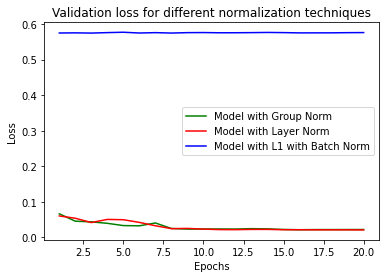

In [18]:
epochs = range(1,21)
plt.plot(epochs, GN_test_losses, 'g', label='Model with Group Norm')
plt.plot(epochs, LN_test_losses, 'r', label='Model with Layer Norm')
plt.plot(epochs, L1_BN_test_losses, 'b', label='Model with L1 with Batch Norm')

plt.title('Validation loss for different normalization techniques')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Test/Validation Accuracy for 3 models together

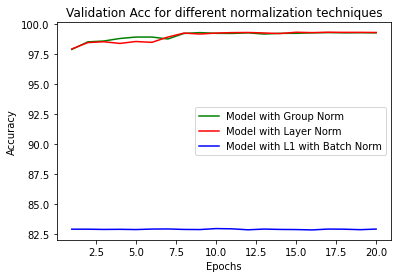

In [19]:
epochs = range(1,21)
plt.plot(epochs, GN_test_acc, 'g', label='Model with Group Norm')
plt.plot(epochs, LN_test_acc, 'r', label='Model with Layer Norm')
plt.plot(epochs, L1_BN_test_acc, 'b', label='Model with L1 with Batch Norm')

plt.title('Validation Acc for different normalization techniques')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#10 misclassified images for model with Group Normalization

In [20]:
def display_misclassified_images(model,
                                test_loader,
                                misclassified_image_row = 2,
                                misclassified_image_col = 5):
    """ This function shows 10 images with their predicted and real labels"""
    incorrect_examples = []
    model.eval()
    with torch.no_grad():
      for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, pred = torch.max(output,1)
        # correct += pred.eq(target.view_as(pred)).sum().item()
        idxs_mask = ((pred == target) == False).nonzero()
        # idxs_mask = (pred - target != 0)
        match = idxs_mask.cpu().numpy()
        
        
        if (idxs_mask.shape[0] > 0 ):
          mydata = list(match.reshape(-1))
          for i in range(len(mydata)-1):
            incorrect_examples.append(data[i].cpu())
            if (len(incorrect_examples) > 10):
               break
            
            # print(f"mydata:{mydata[i]}")
          # print(f"idxs_mask:{idxs_mask}")
          # print(type(match))
          # print(f"idxs_mask reshaped:{type(match.reshape(-1))})")
          # print(f"idxs_mask list:{list(match.reshape(-1))}")
          # print(f"match:{match[0]}, length:{len(match)}")
          # incorrect_examples.append(data[mydata].cpu())
        # if (len(incorrect_examples) > 20):
        #   break ## this is done to ensure we dont store too many images and to save memory
    
   # print(f"Number of misclassified Image:{len(incorrect_examples)}")
    n = 0
    nrows = misclassified_image_row
    ncols = misclassified_image_col
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,)

    for row in range(nrows):
      for col in range(ncols):
        # print(incorrect_examples[n])
        img = incorrect_examples[n]
        # print(img)
        img = img/2 + 0.5
        img = np.clip(img, 0, 1)
        ax[row,col].imshow(img.reshape(28,28))
        
        # print('\n')
        n += 1



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


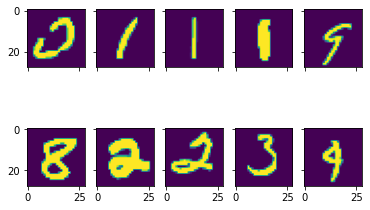

In [21]:
display_misclassified_images(GN_model_obj, test_loader,2, 5)

#10 misclassified images for model with Layer Normalization

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


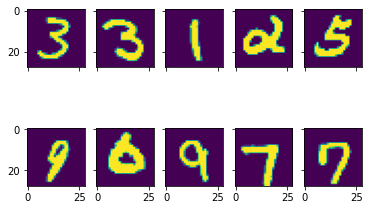

In [22]:
display_misclassified_images(LN_model_obj, test_loader,2, 5)


#10 misclassified images for model with L1 + BatchNormalization

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


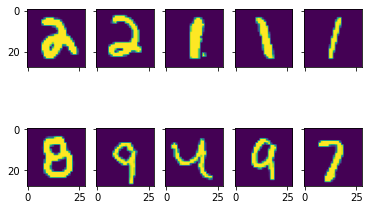

In [23]:
display_misclassified_images(L1_BN_model_obj, test_loader,2, 5)
